#### Libraries

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")

#### Data

In [82]:
cluster_monthly = pd.read_csv("cluster_monthly.csv")

In [84]:
cluster_monthly

,Cluster,date,total_amount
0,0,2010-01-31,1292104.04
1,0,2010-02-28,1227733.58
2,0,2010-03-31,1347335.96
3,0,2010-04-30,1300306.27
4,0,2010-05-31,1333779.14
...,...,...,...
467,3,2019-06-30,1033032.69
468,3,2019-07-31,1061661.16
469,3,2019-08-31,1061982.14
470,3,2019-09-30,1036589.85


#### Holt Winters

In [87]:
def to_month_end(s):
    return pd.to_datetime(s).dt.to_period('M').dt.to_timestamp('M')

def prepare_cluster_series(cluster_monthly, cid, value_col="total_amount"):
    d = cluster_monthly.loc[cluster_monthly["Cluster"] == cid, ["date", value_col]].copy()
    d["date"] = to_month_end(d["date"])
    d[value_col] = d[value_col].astype(str).str.replace(",", "", regex=False).astype(float)
    d = d.sort_values("date")
    y = d.set_index("date")[value_col].asfreq("ME")
    return y

def mape(y, yhat, eps=1e-8):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    return np.mean(np.abs((y - yhat) / np.maximum(np.abs(y), eps))) * 100.0

#### Pre-fit sanity checks / evaluation guards

In [89]:
# --- guards (same discipline as SARIMA) ---
S = 12  # monthly seasonality

def _can_eval_series(y, window=60, horizon=12, s=S):
    if len(y) < window + horizon:
        return False, f"series too short: n={len(y)}, need >= {window + horizon}"
    if window < 2 * s:
        return False, f"window={window} must be >= 2 * seasonality={2*s}"
    return True, ""


#### Metric helper functions (MAE, RMSE, MAPE%)

In [93]:


def mae_fn(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse_fn(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mape_pct(y_true, y_pred):
    """
    MAPE in percent with a zero-safe denominator (sMAPE-like when y_true==0).
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(y_true == 0, (np.abs(y_true) + np.abs(y_pred)) / 2.0, np.abs(y_true))
    return float(np.mean(np.abs(y_true - y_pred) / denom) * 100.0)


In [97]:
from dataclasses import dataclass

@dataclass
class Fold:
    start: pd.Timestamp
    end: pd.Timestamp
    index: pd.DatetimeIndex
    y_true: np.ndarray
    y_pred: np.ndarray
    config: dict


def rolling_eval_hw(
    y: pd.Series,
    window: int = 60,
    horizon: int = 12,
    step: int = 12,
    s: int = 12,
    allow_multiplicative: bool = True
):
    y = y.dropna().asfreq("ME")
    ok, note = _can_eval_series(y, window, horizon, s)
    if not ok:
        return {
            "MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan,
            "folds": [], "segments": [], "preds": [], "actuals": [],
            "configs": [], "notes": note, "steps_ran": 0
        }

    preds_all, acts_all, folds, segs, cfgs = [], [], [], [], []
    n = len(y)
    steps_ran = 0

    for start in range(0, n - window - horizon + 1, step):
        train = y.iloc[start : start + window]
        test  = y.iloc[start + window : start + window + horizon]

        # only allow multiplicative if strictly positive
        allow_mul = allow_multiplicative and (train.min() > 0)

        try:
            best_fit, cfg = fit_best_hw(train, s, allow_mul)  # your existing grid-search HW
            fc = best_fit.forecast(horizon).values
        except Exception as e:
            # failed fold → skip
            continue

        steps_ran += 1
        idx = pd.date_range(start=test.index[0], periods=horizon, freq="M")

        folds.append(Fold(train.index[0], train.index[-1], idx, test.values, fc, cfg))
        segs.append((idx, fc))
        cfgs.append(cfg)

        preds_all.append(fc)
        acts_all.append(test.values)

    if steps_ran == 0:
        return {
            "MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan,
            "folds": [], "segments": [], "preds": [], "actuals": [],
            "configs": [], "notes": "no successful folds", "steps_ran": 0
        }

    y_pred = np.concatenate(preds_all)
    y_true = np.concatenate(acts_all)

    return {
    "MAE":  float(mean_absolute_error(y_true, y_pred)),
    "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
    "MAPE": mape_pct(y_true, y_pred),
    "folds": folds,
    "segments": segs,
    "preds": y_pred,
    "actuals": y_true,
    "configs": cfgs,
    "notes": "",
    "steps_ran": steps_ran
}


In [109]:

WINDOW  = 60   # 5 years train
HORIZON = 12   # 12-step forecast
STEP    = 12   # move by one year
S       = 12   # monthly seasonality

results_rows = []
results_detail = {}

for cid in sorted(cluster_monthly["Cluster"].unique()):
    y = prepare_cluster_series(cluster_monthly, cid, value_col="total_amount")
    out = rolling_eval_hw(y, window=WINDOW, horizon=HORIZON, step=STEP, s=S, allow_multiplicative=True)

    results_detail[cid] = out  # artifacts/configs by cluster

    row = {
        "Cluster": cid,
        "Obs": int(len(y)),
        "Folds": int(out.get("steps_ran", 0)),
        "MAPE": out["MAPE"],
        "MAE": out["MAE"],
        "RMSE": out["RMSE"],
        
    }
    results_rows.append(row)

df_results_hw = pd.DataFrame(results_rows).sort_values("Cluster").reset_index(drop=True)
df_results_hw


,Cluster,Obs,Folds,MAPE,MAE,RMSE
0,0,118,4,1.174537,16244.618426,20683.598088
1,1,118,4,1.460923,23481.371285,29764.337927
2,2,118,4,1.555831,23765.849112,29204.622646
3,3,118,4,2.081832,21491.835927,26515.239196


In [111]:

cluster_sizes = {0: 3437186, 1: 4594314, 2: 2572134, 3: 2031593}

def add_per_person(df, cluster_sizes: dict):
    df = df.copy()
    df["MAE_per_person"]  = df.apply(lambda r: r["MAE"]  / cluster_sizes.get(int(r["Cluster"]), np.nan), axis=1)
    df["RMSE_per_person"] = df.apply(lambda r: r["RMSE"] / cluster_sizes.get(int(r["Cluster"]), np.nan), axis=1)
    return df

df_results_hw = add_per_person(df_results_hw, cluster_sizes)
df_results_hw


,Cluster,Obs,Folds,MAPE,MAE,RMSE,MAE_per_person,RMSE_per_person
0,0,118,4,1.174537,16244.618426,20683.598088,0.004726,0.006018
1,1,118,4,1.460923,23481.371285,29764.337927,0.005111,0.006479
2,2,118,4,1.555831,23765.849112,29204.622646,0.009240,0.011354
3,3,118,4,2.081832,21491.835927,26515.239196,0.010579,0.013051


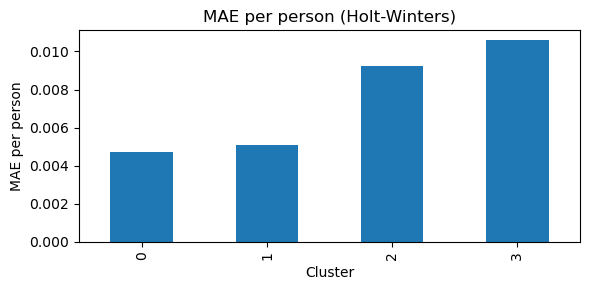

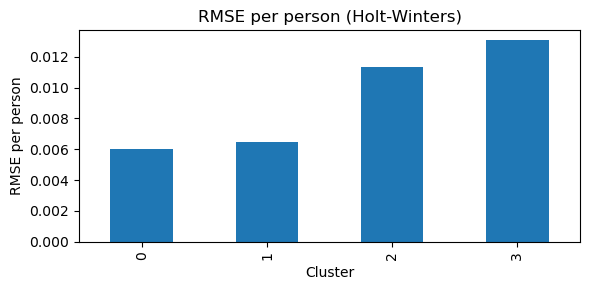

In [107]:
if {"MAE_per_person","RMSE_per_person"}.issubset(df_results_hw.columns):
    ax = df_results_hw.set_index("Cluster")["MAE_per_person"].plot(kind="bar", figsize=(6,3))
    ax.set_title("MAE per person (Holt-Winters)"); ax.set_ylabel("MAE per person")
    plt.tight_layout(); plt.show()

    ax = df_results_hw.set_index("Cluster")["RMSE_per_person"].plot(kind="bar", figsize=(6,3))
    ax.set_title("RMSE per person (Holt-Winters)"); ax.set_ylabel("RMSE per person")
    plt.tight_layout(); plt.show()


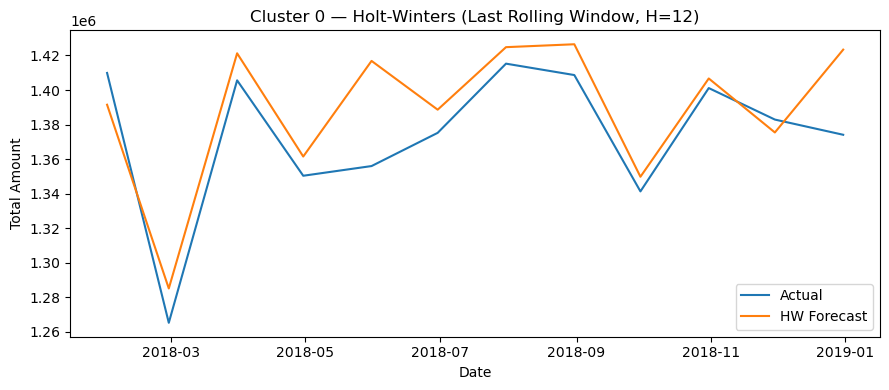

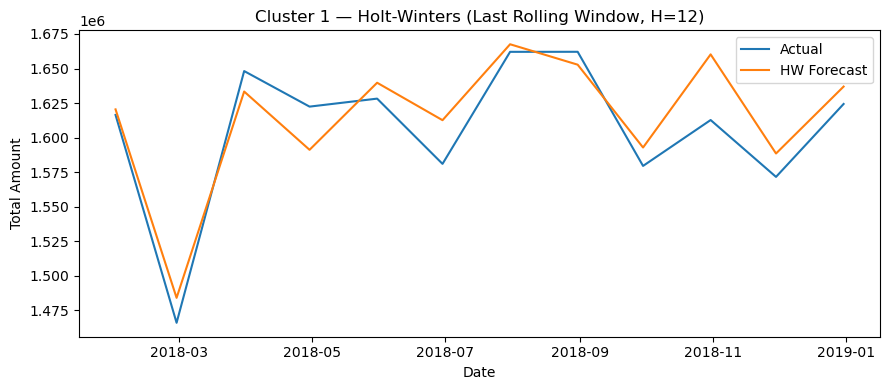

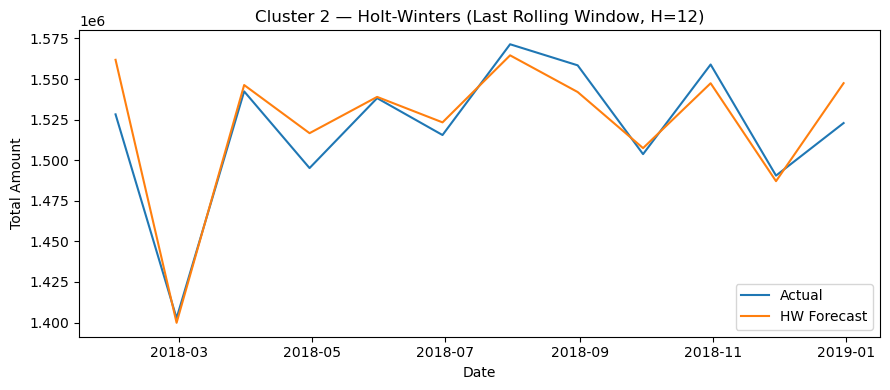

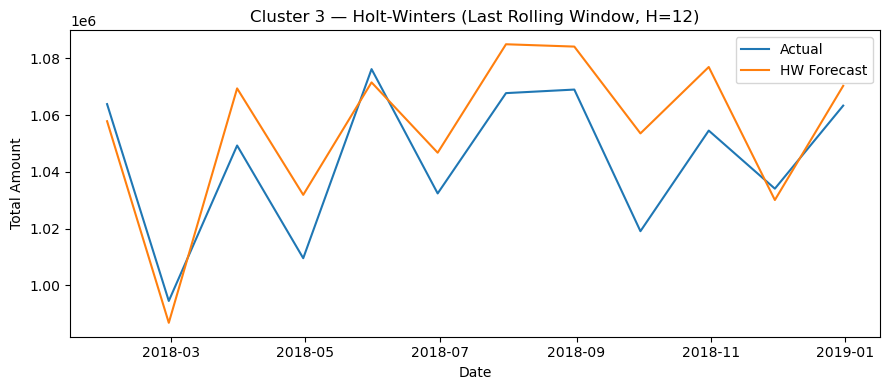

In [105]:
for cid in sorted(results_detail.keys()):
    det = results_detail[cid]
    folds = det["folds"]
    if not folds:
        print(f"Cluster {cid}: no successful folds to plot")
        continue

    last = folds[-1]
    plt.figure(figsize=(9,4))
    plt.plot(last.index, last.y_true, label="Actual")
    plt.plot(last.index, last.y_pred, label="HW Forecast")
    plt.title(f"Cluster {cid} — Holt-Winters (Last Rolling Window, H={HORIZON})")
    plt.xlabel("Date"); plt.ylabel("Total Amount")
    plt.legend(); plt.tight_layout()
    plt.show()
